In [1]:
!pip install -qU pandas matplotlib seaborn python-dotenv langchain langchain-core langchain-community langchain-text-splitters langchain-openai langchain-chroma transformers[torch] streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.4/441.4 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 131.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.1 MB/s eta 0:

# Truncating Category
We have lot of categories in books, collapsing these raw categories into a curated set of broad, insight-driven genres gives your recommender denser, cleaner signals—boosting both model quality (accuracy, coverage) and user experience.

### Grouping a long tail of fine-grained genres into a handful of broader, “insightful” buckets can dramatically improve your recommender in several ways:

1. Reduce Sparsity & Dimensionality

 * Problem: If you one-hot encode 300+ niche categories, almost every book vector is mostly zeros—and your model struggles to learn meaningful co-occurrence.

 * Benefit: Collapsing those into, say, 10–15 high-level genres turns hundreds of dimensions into a small, dense feature space that’s easier to train on and generalize from.

2. Combat the Long Tail

 * Problem: Most categories have only a handful of books. A pure collaborative filter or content-based model can’t learn reliable signals from those rare labels.

 * Benefit: By rolling rare categories into “Other” or grouping them under broader themes (e.g. “History & Biography” vs. “Photography”), you ensure every bucket has enough data to model user preferences.

3. Improve Serendipity & Coverage

 * Problem: Very granular tags tend to reinforce popularity bias—the system keeps recommending the same tiny set of micro-genres to specialists.

 * Benefit: Broader categories let you mix in adjacent interests. Someone who likes “Cyberpunk” and “Dystopian” both map to “Sci-Fi,” so you can confidently recommend a classic space-opera they might otherwise miss.

4. Noise Reduction

 * Problem: User-entered or scraped category fields often contain typos, overlapping synonyms, or mis-tagged labels (e.g. “YA,” “Young Adult,” “Young-Adult”).

 * Benefit: A controlled vocabulary of high-level genres normalizes these variants, so your model learns real taste signals instead of chasing random noise.

5. Faster, More Stable Training

 * Problem: High-dimensional sparse features inflate memory use and slow down similarity computations (cosine / dot-product) or matrix factorizations.

 * Benefit: Fewer, well-populated category features let you train embeddings, tree ensembles, or factorization machines more quickly and with less overfitting risk.

6. Better Interpretability & UX

 * Problem: End users don’t care that a book is tagged “Historical-Adventure-Romance”; they want to browse “History” or “Romance.”

 * Benefit: Presenting a small, intuitive set of categories in your UI (and feeding those into recommendation logic) makes your system’s suggestions more transparent and actionable.

In [2]:
import pandas as pd

df = pd.read_csv('/content/cleanedData.csv')
df.head(5)

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,average_rating_rounded,desc_len,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,3.8,1154,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,3.8,1200,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,3.9,359,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,4.2,295,The Four Loves,9780006280897 Lewis' work on the nature of lov...
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,4.1,465,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."




```
df["categories"].value_counts()
```


you get a Series where:

The index is each unique category

The values are the counts for each category



In [3]:
df["categories"].value_counts()

,count
categories,
Fiction,2111
Juvenile Fiction,390
Biography & Autobiography,311
History,207
Literary Criticism,124
...,...
Human-animal relationships,1
Imperialism,1
Aged women,1


By chaining .reset_index(), you:

Turn the old index into a regular column called "index" by default.

Create a new default integer index (0, 1, 2, …) for the rows.



In [4]:
df["categories"].value_counts().reset_index()

,categories,count
0,Fiction,2111
1,Juvenile Fiction,390
2,Biography & Autobiography,311
3,History,207
4,Literary Criticism,124
...,...,...
474,Human-animal relationships,1
475,Imperialism,1
476,Aged women,1
477,Humorous stories,1


As we observe, category is completely skewed, lot of category are appearing only 1 time.

# Lets Explore and see how many makes sense

In [5]:
df["categories"].value_counts().reset_index().query("count > 50")

,categories,count
0,Fiction,2111
1,Juvenile Fiction,390
2,Biography & Autobiography,311
3,History,207
4,Literary Criticism,124
5,Religion,117
6,Philosophy,117
7,Comics & Graphic Novels,116
8,Drama,86
9,Juvenile Nonfiction,57


#### Lets check if Description of Juvenile Fiction and Juvenile NonFiction makes sense

In [6]:
df[df["categories"] == "Juvenile Fiction"]

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,average_rating_rounded,desc_len,title_and_subtitle,tagged_description
30,9780006646006,000664600X,Ocean Star Express,Mark Haddon;Peter Sutton,Juvenile Fiction,http://books.google.com/books/content?id=I2QZA...,Joe and his parents are enjoying a summer holi...,2002.0,3.50,32.0,1.0,3.5,667,Ocean Star Express,9780006646006 Joe and his parents are enjoying...
79,9780020442608,0020442602,The voyage of the Dawn Treader,Clive Staples Lewis,Juvenile Fiction,http://books.google.com/books/content?id=fDD3C...,"The ""Dawn Treader"" is the first ship Narnia ha...",1970.0,4.09,216.0,2869.0,4.1,371,The voyage of the Dawn Treader,"9780020442608 The ""Dawn Treader"" is the first ..."
85,9780030547744,0030547741,Where the Red Fern Grows,Wilson Rawls,Juvenile Fiction,http://books.google.com/books/content?id=IHpRw...,A young boy living in the Ozarks achieves his ...,2000.0,4.37,288.0,95.0,4.4,149,Where the Red Fern Grows: The Story of Two Dog...,9780030547744 A young boy living in the Ozarks...
86,9780060000141,0060000147,Poppy's Return,Avi,Juvenile Fiction,http://books.google.com/books/content?id=XbcMJ...,"There's trouble at Gray House, the girlhood ho...",2006.0,3.99,256.0,1086.0,4.0,512,Poppy's Return,"9780060000141 There's trouble at Gray House, t..."
87,9780060001537,0060001534,Diary of a Spider,Doreen Cronin,Juvenile Fiction,http://books.google.com/books/content?id=UWvZo...,This is the diary ... of a spider. But don't b...,2005.0,4.25,40.0,7903.0,4.2,507,Diary of a Spider,9780060001537 This is the diary ... of a spide...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4845,9781590385814,1590385810,Fablehaven,Brandon Mull,Juvenile Fiction,http://books.google.com/books/content?id=tbVIP...,When Kendra and Seth go to stay at their grand...,2006.0,4.09,351.0,111896.0,4.1,173,Fablehaven,9781590385814 When Kendra and Seth go to stay ...
4930,9781596792500,1596792507,Sherlock Holmes and the Case of the Hound of t...,Arthur Conan Doyle;Malvina G. Vogel,Juvenile Fiction,http://books.google.com/books/content?id=EWgWP...,Sherlock Holmes and Dr. Watson travel to the b...,2005.0,4.51,237.0,28.0,4.5,156,Sherlock Holmes and the Case of the Hound of t...,9781596792500 Sherlock Holmes and Dr. Watson t...
4942,9781599900056,159990005X,The Drift House,Dale Peck,Juvenile Fiction,http://books.google.com/books/content?id=kbwPY...,Sent to stay with their uncle in a ship-like h...,2006.0,3.64,437.0,595.0,3.6,213,The Drift House: The First Voyage,9781599900056 Sent to stay with their uncle in...
5010,9781844580514,1844580512,Attack of the Jaguar,M. A. Harvey,Juvenile Fiction,http://books.google.com/books/content?id=3HUdt...,This training manual for operatives of Xtreme ...,2004.0,3.40,125.0,4.0,3.4,224,Attack of the Jaguar,9781844580514 This training manual for operati...


In [7]:
df[df["categories"] == "Juvenile Nonfiction"]

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,average_rating_rounded,desc_len,title_and_subtitle,tagged_description
107,9780060277406,0060277408,The Secret Garden Cookbook,Amy Cotler,Juvenile Nonfiction,http://books.google.com/books/content?id=c7E_H...,Frances Hodgson Burnett's The Secret Garden de...,1999.0,4.28,128.0,142.0,4.3,1105,The Secret Garden Cookbook: Recipes Inspired b...,9780060277406 Frances Hodgson Burnett's The Se...
108,9780060278427,0060278420,Laura's Album,William Anderson,Juvenile Nonfiction,http://books.google.com/books/content?id=_zTkq...,Though best known as the author of the Little ...,1998.0,4.30,80.0,713.0,4.3,822,Laura's Album: A Remembrance Scrapbook of Laur...,9780060278427 Though best known as the author ...
228,9780060782139,0060782137,Time For Kids: Butterflies!,Editors of TIME For Kids,Juvenile Nonfiction,http://books.google.com/books/content?id=OdZxn...,"Butterflies There are 20,000 different kinds o...",2006.0,4.00,32.0,20.0,4.0,310,Time For Kids: Butterflies!,"9780060782139 Butterflies There are 20,000 dif..."
267,9780060882600,0060882603,The Annotated Charlotte's Web,E. B. White,Juvenile Nonfiction,http://books.google.com/books/content?id=vaYYH...,"Charlotte's Web, one of America's best-loved c...",2006.0,4.16,320.0,41.0,4.2,494,The Annotated Charlotte's Web,"9780060882600 Charlotte's Web, one of America'..."
434,9780064462044,0064462048,My Little House Crafts Book,Carolyn Strom Collins,Juvenile Nonfiction,http://books.google.com/books/content?id=lTzrs...,Make the same pioneer crafts that Laura did! I...,1998.0,4.05,64.0,56.0,4.0,831,My Little House Crafts Book: 18 Projects from ...,9780064462044 Make the same pioneer crafts tha...
435,9780064462341,006446234X,Pioneer Girl,William Anderson,Juvenile Nonfiction,http://books.google.com/books/content?id=Sj4UD...,The pioneer spirit lives on... Readers around ...,2000.0,4.15,32.0,414.0,4.2,1663,Pioneer Girl: The Story of Laura Ingalls Wilder,9780064462341 The pioneer spirit lives on... R...
439,9780066236179,0066236177,A Light in the Attic Book and CD,Shel Silverstein,Juvenile Nonfiction,http://books.google.com/books/content?id=FJfQs...,Last night while I lay thinking here Some What...,2001.0,4.34,176.0,590.0,4.3,977,A Light in the Attic Book and CD,9780066236179 Last night while I lay thinking ...
812,9780142302279,0142302279,Dirty Beasts,Roald Dahl,Juvenile Nonfiction,NaN,Poems tell the stories of a smart pig who outw...,2002.0,4.02,32.0,3953.0,4.0,188,Dirty Beasts,9780142302279 Poems tell the stories of a smar...
821,9780142407226,0142407224,The Tough Guide to Fantasyland,Diana Wynne Jones,Juvenile Nonfiction,http://books.google.com/books/content?id=v5jxA...,A unique guide to fantasy literature helps rea...,2006.0,3.94,234.0,3897.0,3.9,225,The Tough Guide to Fantasyland,9780142407226 A unique guide to fantasy litera...
823,9780142407929,0142407925,The BFG,Roald Dahl;David Wood;Jane Walmsley,Juvenile Nonfiction,http://books.google.com/books/content?id=aDf-O...,"With notes on staging, props, and costumes, a ...",2007.0,4.26,128.0,452.0,4.3,163,The BFG: A Set of Plays,"9780142407929 With notes on staging, props, an..."


## Mapping

For simplicity lets map the category that are appearing more than 50 times as fiction and Non Fiction, the remaining will be marked as NA and we will use text classification model to make predictions for those as per the description.


In [8]:
category_mapping = {'Fiction' : "Fiction",
 'Juvenile Fiction': "Children's Fiction",
 'Biography & Autobiography': "Nonfiction",
 'History': "Nonfiction",
 'Literary Criticism': "Nonfiction",
 'Philosophy': "Nonfiction",
 'Religion': "Nonfiction",
 'Comics & Graphic Novels': "Fiction",
 'Drama': "Fiction",
 'Juvenile Nonfiction': "Children's Nonfiction",
 'Science': "Nonfiction",
 'Poetry': "Fiction"}

In [9]:
df["simple_categories"] = df["categories"].map(category_mapping)

In [10]:
df.head(10)

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,average_rating_rounded,desc_len,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,3.8,1154,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,3.8,1200,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,NaN
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,3.9,359,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,4.2,295,The Four Loves,9780006280897 Lewis' work on the nature of lov...,NaN
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,4.1,465,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",NaN
5,9780006380832,0006380832,Empires of the Monsoon,Richard Hall,"Africa, East",http://books.google.com/books/content?id=MuPEQ...,Until Vasco da Gama discovered the sea-route t...,1998.0,4.41,608.0,65.0,4.4,468,Empires of the Monsoon: A History of the India...,9780006380832 Until Vasco da Gama discovered t...,NaN
6,9780006470229,000647022X,The Gap Into Madness,Stephen R. Donaldson,"Hyland, Morn (Fictitious character)",http://books.google.com/books/content?id=4oXav...,A new-cover reissue of the fourth book in the ...,1994.0,4.15,743.0,103.0,4.2,946,The Gap Into Madness: Chaos and Order,9780006470229 A new-cover reissue of the fourt...,NaN
7,9780006472612,0006472613,Master of the Game,Sidney Sheldon,Adventure stories,http://books.google.com/books/content?id=TkTYp...,Kate Blackwell is an enigma and one of the mos...,1982.0,4.11,489.0,43540.0,4.1,174,Master of the Game,9780006472612 Kate Blackwell is an enigma and ...,NaN
8,9780006482079,0006482074,Warhost of Vastmark,Janny Wurts,Fiction,http://books.google.com/books/content?id=uOL0f...,"Tricked once more by his wily half-brother, Ly...",1995.0,4.03,522.0,2966.0,4.0,829,Warhost of Vastmark,9780006482079 Tricked once more by his wily ha...,Fiction
9,9780006483014,0006483011,The Once and Future King,Terence Hanbury White,Arthurian romances,http://books.google.com/books/content?id=Jx6Bv...,An omnibus volume of the author's complete sto...,1996.0,4.04,823.0,2805.0,4.0,270,The Once and Future King,9780006483014 An omnibus volume of the author'...,NaN


In [11]:
# Books where simple category is NA

df[df["simple_categories"].isna()]

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,average_rating_rounded,desc_len,title_and_subtitle,tagged_description,simple_categories
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,3.8,1200,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,NaN
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,4.2,295,The Four Loves,9780006280897 Lewis' work on the nature of lov...,NaN
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,4.1,465,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",NaN
5,9780006380832,0006380832,Empires of the Monsoon,Richard Hall,"Africa, East",http://books.google.com/books/content?id=MuPEQ...,Until Vasco da Gama discovered the sea-route t...,1998.0,4.41,608.0,65.0,4.4,468,Empires of the Monsoon: A History of the India...,9780006380832 Until Vasco da Gama discovered t...,NaN
6,9780006470229,000647022X,The Gap Into Madness,Stephen R. Donaldson,"Hyland, Morn (Fictitious character)",http://books.google.com/books/content?id=4oXav...,A new-cover reissue of the fourth book in the ...,1994.0,4.15,743.0,103.0,4.2,946,The Gap Into Madness: Chaos and Order,9780006470229 A new-cover reissue of the fourt...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5190,9788125026600,8125026606,Nietzsche For Beginners,Marc Sautet,NaN,http://books.google.com/books/content?id=fPIv8...,Not only does Nietzsche for Beginners delve in...,2004.0,3.26,192.0,21.0,3.3,301,Nietzsche For Beginners,9788125026600 Not only does Nietzsche for Begi...,NaN
5191,9788171565641,8171565646,Aspects of the Novel,E. M. Forster,English fiction,http://books.google.com/books/content?id=qWU9P...,"Forster's lively, informed originality and wit...",2004.0,3.83,141.0,10.0,3.8,290,Aspects of the Novel,"9788171565641 Forster's lively, informed origi...",NaN
5192,9788172235222,8172235224,Mistaken Identity,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,2.9,1641,Mistaken Identity,9788172235222 On A Train Journey Home To North...,NaN
5193,9788173031014,8173031010,Journey to the East,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,3.7,373,Journey to the East,9788173031014 This book tells the tale of a ma...,NaN


In [12]:
# Book with simple category

df[~(df["simple_categories"].isna())]

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,average_rating_rounded,desc_len,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,3.8,1154,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,3.9,359,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
8,9780006482079,0006482074,Warhost of Vastmark,Janny Wurts,Fiction,http://books.google.com/books/content?id=uOL0f...,"Tricked once more by his wily half-brother, Ly...",1995.0,4.03,522.0,2966.0,4.0,829,Warhost of Vastmark,9780006482079 Tricked once more by his wily ha...,Fiction
30,9780006646006,000664600X,Ocean Star Express,Mark Haddon;Peter Sutton,Juvenile Fiction,http://books.google.com/books/content?id=I2QZA...,Joe and his parents are enjoying a summer holi...,2002.0,3.50,32.0,1.0,3.5,667,Ocean Star Express,9780006646006 Joe and his parents are enjoying...,Children's Fiction
46,9780007121014,0007121016,Taken at the Flood,Agatha Christie,Fiction,http://books.google.com/books/content?id=3gWlx...,A Few Weeks After Marrying An Attractive Young...,2002.0,3.71,352.0,8852.0,3.7,581,Taken at the Flood,9780007121014 A Few Weeks After Marrying An At...,Fiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5178,9781933648279,1933648279,Night Has a Thousand Eyes,Cornell Woolrich,Fiction,http://books.google.com/books/content?id=3Gk6s...,"""Cornell Woolrich's novels define the essence ...",2007.0,3.77,344.0,680.0,3.8,629,Night Has a Thousand Eyes,"9781933648279 ""Cornell Woolrich's novels defin...",Fiction
5188,9784770028969,4770028962,Coin Locker Babies,村上龍,Fiction,http://books.google.com/books/content?id=87DJw...,Rescued from the lockers in which they were le...,2002.0,3.75,393.0,5560.0,3.8,237,Coin Locker Babies,9784770028969 Rescued from the lockers in whic...,Fiction
5189,9788122200850,8122200850,"Cry, the Peacock",Anita Desai,Fiction,http://books.google.com/books/content?id=_QKwV...,This book is the story of a young girl obsesse...,1980.0,3.22,218.0,134.0,3.2,181,"Cry, the Peacock",9788122200850 This book is the story of a youn...,Fiction
5195,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,4.5,1018,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...,Nonfiction


# Building Text Classification

In [13]:
from transformers import pipeline


pipe = pipeline("zero-shot-classification",
                model="facebook/bart-large-mnli")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In Pandas, .loc is a label-based indexer used to access a group of rows and columns by their labels or by a boolean array.



```
sequence = (
    books
      .loc[df["simple_categories"] == "Fiction", "description"]  # 1
      .reset_index(drop=True)                                       # 2
      [0]                                                           # 3
)
```

1. df.loc[...]

* The mask df["simple_categories"] == "Fiction" selects all rows where the simplified genre is “Fiction”.

* By specifying , "description" you pull just that column, so you end up with a Series of all Fiction descriptions.

2. .reset_index(drop=True)

* Resets the Series’ index back to 0, 1, 2, … instead of whatever row numbers they originally had.

* drop=True means “don’t keep the old index as a column.”

3. [0]

* Grabs the very first element (at new index position 0) of that reset Series

In [14]:
sequence = df.loc[df["simple_categories"] == "Fiction", "description"].reset_index(drop=True)[0]

In [15]:
candidate_labels = ["Fiction", "Nonfiction"]
pipe(sequence, candidate_labels)

{'sequence': 'A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers. It’s 1956 in Gilead, Iowa, towards the end of the Reverend Ames’s life, and he is absorbed in recording his family’s story, a legacy for the young son he will never see grow up. Haunted by his grandfather’s presence, John tells of the rift between his grandfather and his father: the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist. He is troubled, too, by his prodigal namesake, Jack (John Ames) Boughton, his best friend’s lost son who returns to Gilead searching for forgiveness and redemption. Told in John Ames’s joyous, rambling voice that finds beauty, humour and truth in the smallest of life’s details, Gilead is a song of celebration and acceptance of the best and the worst

In [16]:
import numpy as np

max_index = np.argmax(pipe(sequence, candidate_labels)["scores"])
max_label = pipe(sequence, candidate_labels)["labels"][max_index]
max_index , max_label

(np.int64(0), 'Fiction')

# Pipeline
Build pipeline to make predictions for simple_categories, we will store the actual category and predicted category,
lets start with Fiction and then do it for NonFiction and then check the accuracy

In [17]:
def generate_predictions(sequence, candidate_labels):
  predictions = pipe(sequence, candidate_labels)

  max_index = np.argmax(predictions["scores"])
  max_label = predictions["labels"][max_index]

  return max_label

### For Fiction Class

In [18]:
from tqdm import tqdm

actual_cats = [] # actual class
predicted_cats = [] # the predicted class

for i in tqdm(range(0, 300)):
    sequence = df.loc[df["simple_categories"] == "Fiction", "description"].reset_index(drop=True)[i]

    predicted_cats += [generate_predictions(sequence, candidate_labels)]

    actual_cats += ["Fiction"]

100%|██████████| 300/300 [00:44<00:00,  6.73it/s]


In [19]:
for i in tqdm(range(0, 300)):
    sequence = df.loc[df["simple_categories"] == "Nonfiction", "description"].reset_index(drop=True)[i]

    predicted_cats += [generate_predictions(sequence, candidate_labels)]

    actual_cats += ["Nonfiction"]

100%|██████████| 300/300 [00:30<00:00,  9.80it/s]


In [20]:
# Create a Dataframe to view them side by side
predictions_df = pd.DataFrame({"actual_categories": actual_cats, "predicted_categories": predicted_cats})

In [21]:
predictions_df

,actual_categories,predicted_categories
0,Fiction,Fiction
1,Fiction,Fiction
2,Fiction,Fiction
3,Fiction,Nonfiction
4,Fiction,Fiction
...,...,...
595,Nonfiction,Nonfiction
596,Nonfiction,Fiction
597,Nonfiction,Nonfiction
598,Nonfiction,Nonfiction


In [22]:
# add a new column, correct prediction give value 1 else 0
predictions_df["correct_prediction"] = (
    np.where(predictions_df["actual_categories"] == predictions_df["predicted_categories"], 1, 0)
)

In [23]:
predictions_df

,actual_categories,predicted_categories,correct_prediction
0,Fiction,Fiction,1
1,Fiction,Fiction,1
2,Fiction,Fiction,1
3,Fiction,Nonfiction,0
4,Fiction,Fiction,1
...,...,...,...
595,Nonfiction,Nonfiction,1
596,Nonfiction,Fiction,0
597,Nonfiction,Nonfiction,1
598,Nonfiction,Nonfiction,1


In [24]:
accuracy = predictions_df["correct_prediction"].sum() / len(predictions_df)

print("Text classification model has a accuracy of {accuracy}".format(accuracy=accuracy))

Text classification model has a accuracy of 0.7783333333333333


# Using Model

Once we have the model ready, lets start making prediction for NA value in the simple_categories

df["simple_categories"].isna()
Builds a Boolean mask that’s True for every row where simple_categories is missing (NaN).

df.loc[ mask , ["isbn13","description"] ]
Uses that mask to select only the rows with missing simple_categories, and from each of those rows pulls just the isbn13 and description columns.

.reset_index(drop=True)
Resets the resulting DataFrame’s row labels to 0,1,2,… instead of the original indices. drop=True means “discard the old index rather than turning it into a column.”

In [25]:
isbns = []
predicted_cats = []

missing_cats = df.loc[df["simple_categories"].isna(), ["isbn13", "description"]].reset_index(drop=True)

In [26]:
missing_cats

,isbn13,description
0,9780002261982,A new 'Christie for Christmas' -- a full-lengt...
1,9780006280897,Lewis' work on the nature of love divides love...
2,9780006280934,"""In The Problem of Pain, C.S. Lewis, one of th..."
3,9780006380832,Until Vasco da Gama discovered the sea-route t...
4,9780006470229,A new-cover reissue of the fourth book in the ...
...,...,...
1449,9788125026600,Not only does Nietzsche for Beginners delve in...
1450,9788171565641,"Forster's lively, informed originality and wit..."
1451,9788172235222,On A Train Journey Home To North India After L...
1452,9788173031014,This book tells the tale of a man who goes on ...


In [27]:
for i in tqdm(range(0, len(missing_cats))):
  sequence = missing_cats["description"][i]

  predicted_cats += [generate_predictions(sequence, candidate_labels)]

  isbns += [missing_cats["isbn13"][i]]

100%|██████████| 1454/1454 [02:27<00:00,  9.83it/s]


In [29]:
print("id: {isbn} and prediction: {predicted_cats}".format(isbn=isbns[0], predicted_cats=predicted_cats[0]))

id: 9780002261982 and prediction: Fiction


In [30]:
missing_predicted_df = pd.DataFrame({"isbn13": isbns, "predicted_categories": predicted_cats})

In [31]:
missing_predicted_df

,isbn13,predicted_categories
0,9780002261982,Fiction
1,9780006280897,Nonfiction
2,9780006280934,Nonfiction
3,9780006380832,Nonfiction
4,9780006470229,Fiction
...,...,...
1449,9788125026600,Nonfiction
1450,9788171565641,Fiction
1451,9788172235222,Fiction
1452,9788173031014,Nonfiction


# Joins

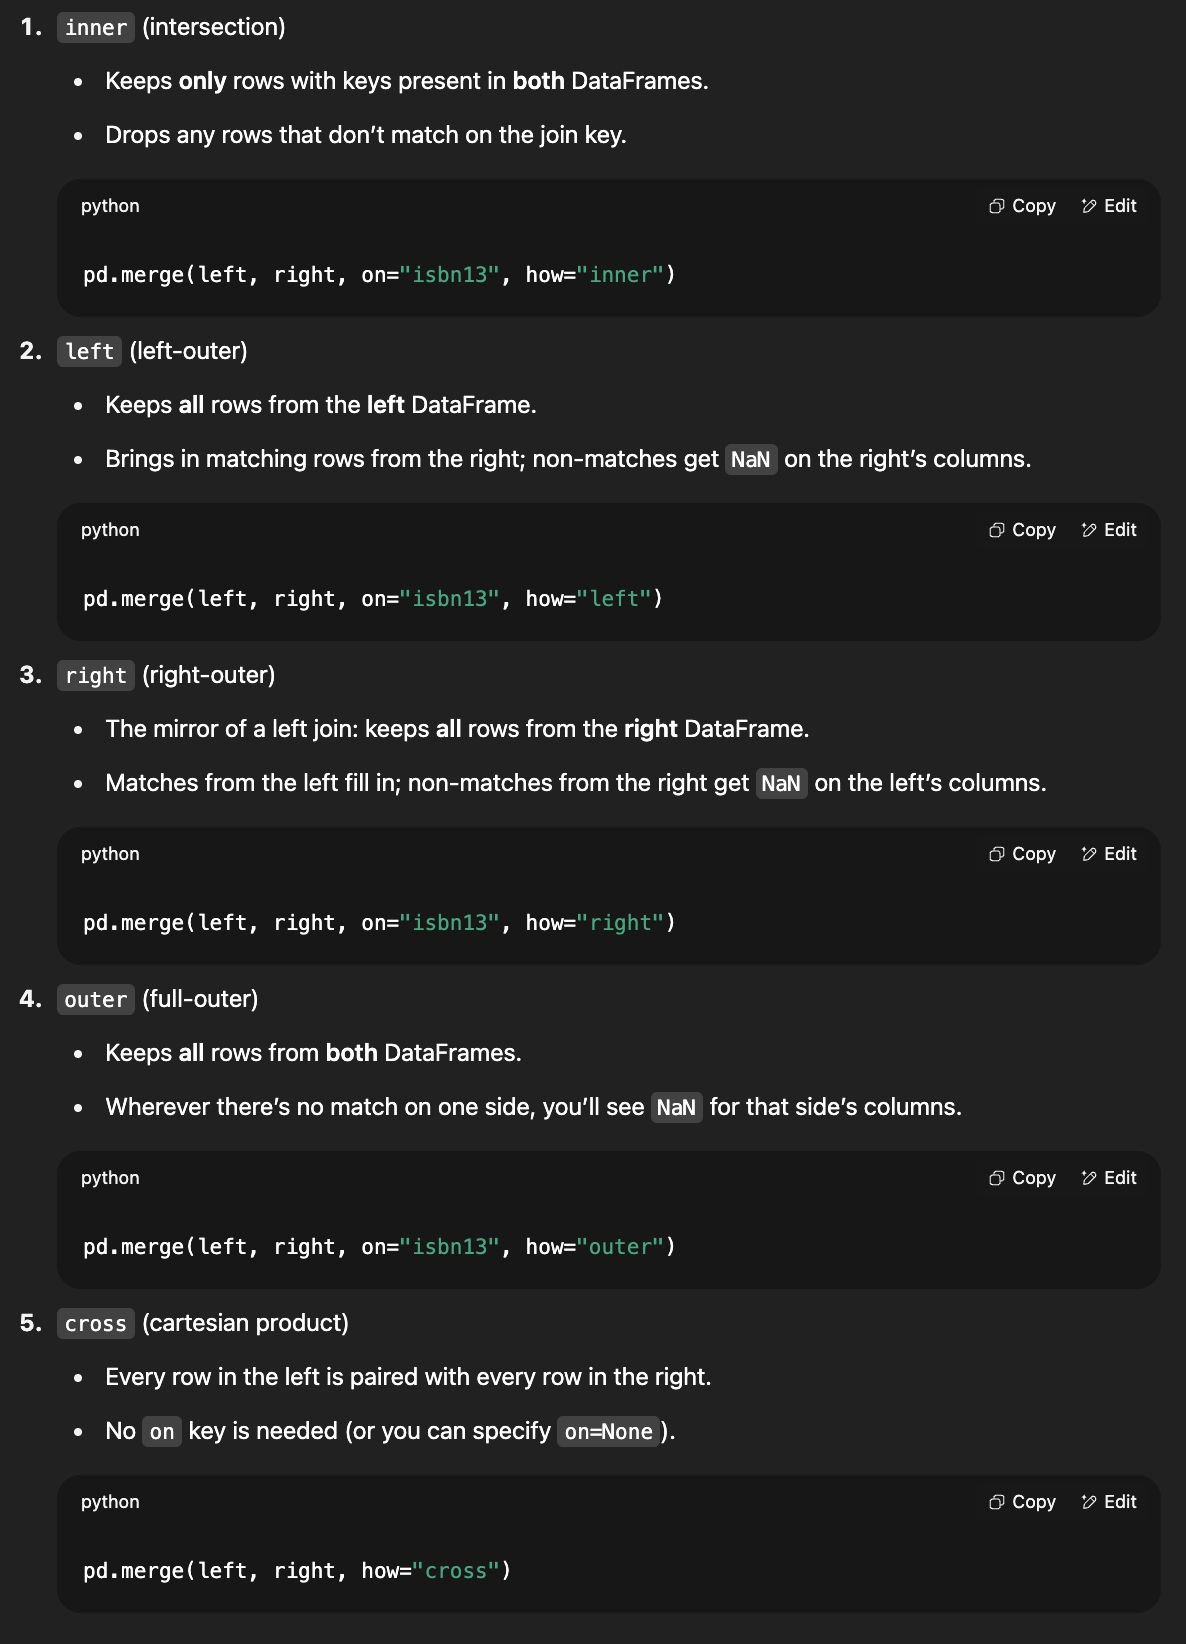

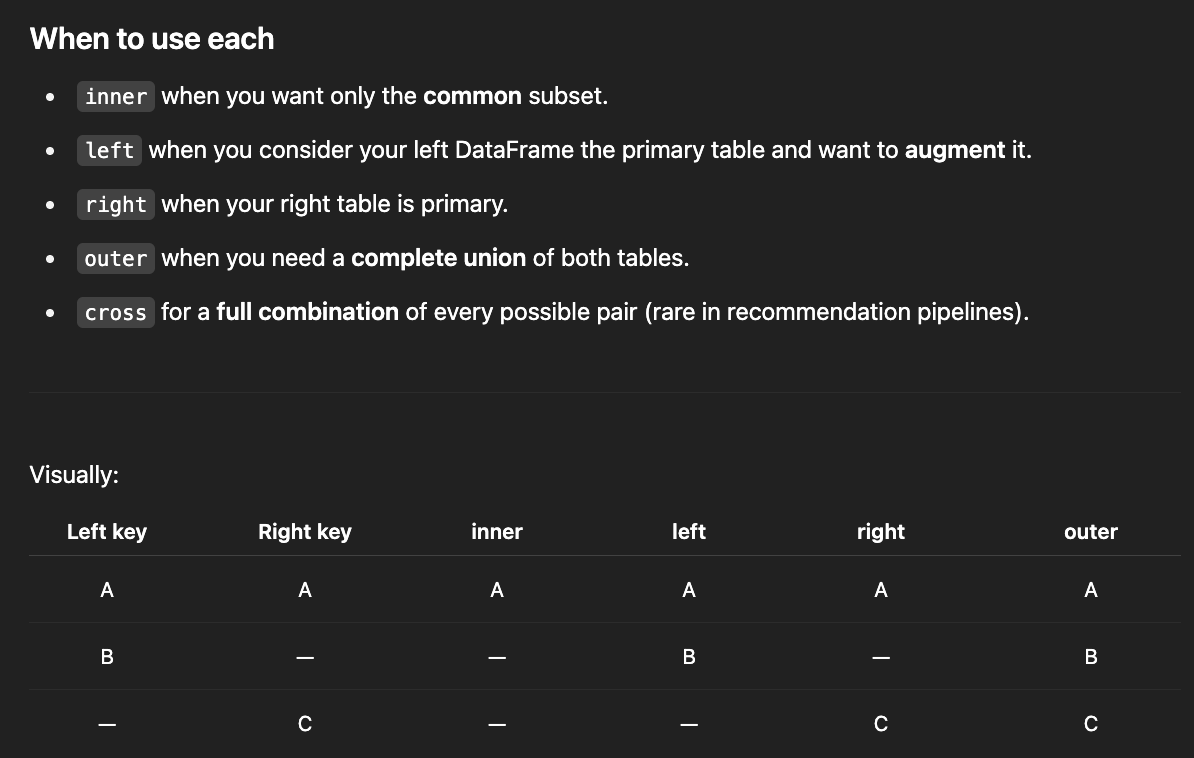

### Left Join
A left join (in pandas via pd.merge(..., how="left")) means:

1. Start with every row in your left DataFrame (df).

2. Look up matching rows in your right DataFrame (missing_predicted_df) based on the key column—in this case, "isbn13".

3. Attach any columns from the right frame (here, predicted_categories) when there’s a match.

4/ If there’s no match, you still keep the left-frame row, but fill the new columns with NaN.

Visually:

```
 Left DF         Right DF         Result of Left Join
--------       ----------        --------------------
A isbn13=1     1 → Sci-Fi        A isbn13=1 Sci-Fi
B isbn13=2     3 → Mystery       B isbn13=2    NaN
C isbn13=3                       C isbn13=3 Mystery

```

* Row A finds a prediction, so it gets filled in.

* Row B had no prediction, so it stays in the result with a blank.

* Row C (a key in the right only) isn’t brought in at all, because we only keep left-frame rows.

#### Why use isbn13 as the key?
* Uniqueness: ISBN-13 is a globally unique identifier for each book edition—no two different books share the same ISBN-13.

* Consistency: Both your original DataFrame and your missing_predicted_df of model outputs use ISBN-13 to refer to books, so it’s the natural column on which to align them.

* Correctness: Merging on a unique key ensures that you don’t accidentally duplicate rows or mix up predictions for the wrong book.

In [32]:
# 1. Bringing in your predictions
"""
You’re doing a left-join on the "isbn13" key
so that every book in your main df now gets a new column, "predicted_categories",
wherever there was a match in missing_predicted_df (which holds the categories you predicted for books that originally had no simple_categories).
"""

df = pd.merge(df, missing_predicted_df, on="isbn13", how="left")


In [33]:
df.head(5)

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,average_rating_rounded,desc_len,title_and_subtitle,tagged_description,simple_categories,predicted_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,3.8,1154,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction,NaN
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,3.8,1200,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,NaN,Fiction
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,3.9,359,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction,NaN
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,4.2,295,The Four Loves,9780006280897 Lewis' work on the nature of lov...,NaN,Nonfiction
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,4.1,465,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",NaN,Nonfiction


2. For each row, if simple_categories is still NaN, replace it with the predicted_categories value; otherwise leave it as it was. In effect, you’re imputing all your missing “simple” labels with the ones your model generated.

In [34]:
# This is like a if statment - if NaN add predicted values else simple_categories value
df["simple_categories"] = np.where(df["simple_categories"].isna(), df["predicted_categories"], df["simple_categories"])

In [35]:
df.head(10)

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,average_rating_rounded,desc_len,title_and_subtitle,tagged_description,simple_categories,predicted_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,3.8,1154,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction,NaN
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,3.8,1200,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,Fiction,Fiction
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,3.9,359,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction,NaN
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,4.2,295,The Four Loves,9780006280897 Lewis' work on the nature of lov...,Nonfiction,Nonfiction
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,4.1,465,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",Nonfiction,Nonfiction
5,9780006380832,0006380832,Empires of the Monsoon,Richard Hall,"Africa, East",http://books.google.com/books/content?id=MuPEQ...,Until Vasco da Gama discovered the sea-route t...,1998.0,4.41,608.0,65.0,4.4,468,Empires of the Monsoon: A History of the India...,9780006380832 Until Vasco da Gama discovered t...,Nonfiction,Nonfiction
6,9780006470229,000647022X,The Gap Into Madness,Stephen R. Donaldson,"Hyland, Morn (Fictitious character)",http://books.google.com/books/content?id=4oXav...,A new-cover reissue of the fourth book in the ...,1994.0,4.15,743.0,103.0,4.2,946,The Gap Into Madness: Chaos and Order,9780006470229 A new-cover reissue of the fourt...,Fiction,Fiction
7,9780006472612,0006472613,Master of the Game,Sidney Sheldon,Adventure stories,http://books.google.com/books/content?id=TkTYp...,Kate Blackwell is an enigma and one of the mos...,1982.0,4.11,489.0,43540.0,4.1,174,Master of the Game,9780006472612 Kate Blackwell is an enigma and ...,Nonfiction,Nonfiction
8,9780006482079,0006482074,Warhost of Vastmark,Janny Wurts,Fiction,http://books.google.com/books/content?id=uOL0f...,"Tricked once more by his wily half-brother, Ly...",1995.0,4.03,522.0,2966.0,4.0,829,Warhost of Vastmark,9780006482079 Tricked once more by his wily ha...,Fiction,NaN
9,9780006483014,0006483011,The Once and Future King,Terence Hanbury White,Arthurian romances,http://books.google.com/books/content?id=Jx6Bv...,An omnibus volume of the author's complete sto...,1996.0,4.04,823.0,2805.0,4.0,270,The Once and Future King,9780006483014 An omnibus volume of the author'...,Fiction,Fiction


In [36]:
# Once you’ve back-filled every missing simple_categories, you no longer need the predicted_categories helper column—so you drop it to keep your DataFrame tidy.
df = df.drop(columns=["predicted_categories"])

In [37]:
df.head(5)

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,average_rating_rounded,desc_len,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,3.8,1154,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,3.8,1200,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,Fiction
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,3.9,359,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,4.2,295,The Four Loves,9780006280897 Lewis' work on the nature of lov...,Nonfiction
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,4.1,465,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",Nonfiction


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isbn13                  5197 non-null   int64  
 1   isbn10                  5197 non-null   object 
 2   title                   5197 non-null   object 
 3   authors                 5165 non-null   object 
 4   categories              5167 non-null   object 
 5   thumbnail               5031 non-null   object 
 6   description             5197 non-null   object 
 7   published_year          5197 non-null   float64
 8   average_rating          5197 non-null   float64
 9   num_pages               5197 non-null   float64
 10  ratings_count           5197 non-null   float64
 11  average_rating_rounded  5197 non-null   float64
 12  desc_len                5197 non-null   int64  
 13  title_and_subtitle      5197 non-null   object 
 14  tagged_description      5197 non-null   

In [39]:
# Compute summary statistics for each column
missing = df.isnull().sum()
duplicates = df.apply(lambda col: col.duplicated(keep=False).sum())
distinct = df.nunique()

summary = pd.DataFrame({
    "missing_count": missing,
    "duplicate_count": duplicates,
    "distinct_count": distinct
}).reset_index().rename(columns={"index": "column"})

In [40]:
summary

,column,missing_count,duplicate_count,distinct_count
0,isbn13,0,0,5197
1,isbn10,0,0,5197
2,title,0,409,4969
3,authors,32,2880,3045
4,categories,30,4860,479
5,thumbnail,166,166,5031
6,description,0,72,5154
7,published_year,0,5183,83
8,average_rating,0,5172,190
9,num_pages,0,4953,808


In [41]:
df.to_csv("text_classification.csv", index=False)